<a href="https://colab.research.google.com/github/SheKJana/first-own-repository/blob/main/Nach_KAQs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Semesteraufgabe BINA- nach KAQs gegliedert**

# Umgebung vorbereiten

In [10]:
#Vorbereitung Blibliotheken und Visualisierungstools hochalde
!pip install scikit-learn
!pip install kaggle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, Markdown


# Daten

Für die Beantwortung unsere Fragen und dem entwickeln des Tools benötigen, wir Daten welche sich dafür eignen.

Datenquelle Bei der Auswahl unserer Datenquellen haben wir uns an folgenden Kriterien orientiert:

- Die Daten mussten die für unsere Fragestellungen relevanten Informationen enthalten, insbesondere Angaben zur individuellen Nährstoffzufuhr und zum Gesundheitszustand.

- Die Daten sollten eine ausreichende Anzahl von Beobachtungen aufweisen, um statistische Analysen (z.B. Clustering) mit gewisser Aussagekraft durchführen zu können.

- Die Struktur der Datensätze sollte grundsätzlich verständlich und weiterverarbeitbar sein – auch wenn wir eine eigene Bereinigung und Aufbereitung vornehmen würden.

Folgende Datensätze von Kaggle haben unsere Anforderungene erfüllt:

**NHANES-Daten**
Ernährungsdaten (diet.csv), Untersuchungsdaten (examination.csv), Diesagnosedaten, Gesundheitsdaten (questionnaire.csv);
Detailed Meals Macros CLEANED und Food and Nutrition
Für den Abgleich mit offiziellen Nährstoffzufuhrs Empfehlungen greifen wir auf die Richtwerte des Bundesamts für Lebensmittelsicherheit und Veterinärwesen
https://www.kaggle.com/datasets/cdc/national-health-and-nutrition-examination-survey


**Food and Nutrition Dataset**

Nährwerte einzelner Lebensmittel (Makros & Mikros)
Ermöglicht detaillierte Aufschlüsselung komplexer Mahlzeiten
https://www.kaggle.com/datasets/utsavdey1410/food-nutrition-dataset/data


Zusätzlich haben wir uns der der offizielen Referentabelle des BLV bedient
(**BLV)**
 Diese gelten als anerkannter Standard in der Schweiz und kommen in der Gesundheitsförderung sowie Ernährungsberatung zum Einsatz. Im Vergleich mit internationalen Richtwerten der WHO stimmen die grundlegenden Zielwerte weitgehend überein.
https://www.blv.admin.ch/blv/de/home/lebensmittel-und-ernaehrung/ernaehrung/empfehlungen-informationen/naehrstoffe/naehrstoffzufuhr-dynamische-tabelle.html

In [30]:
# Block 1 - NHANES CSVs laden und mergen
# Lädt vier Dateien von GitHub (raw.githubusercontent.com),
# behält nur die benötigten Spalten und liefert df_raw.

from __future__ import annotations
from io import StringIO
from pathlib import PurePosixPath
from typing import Dict, List
import logging
import sys

import pandas as pd
import requests
from requests.adapters import HTTPAdapter, Retry

# ---------------------------------------------------------------------------
# 1) Konfiguration
# ---------------------------------------------------------------------------
GH_USER   = "iceangel79"
GH_REPO   = "MScWinf_Gruppenarbeit_Sem2"
GH_REF    = "main"   # alternativ Commit-SHA
GH_FOLDER = "Semesterarbeit/Datasets/Kaggle"

DATASETS: Dict[str, str] = {
    "diet"         : "diet.csv",
    "examination"  : "examination.csv",
    "questionnaire": "questionnaire.csv",
    "demographic"  : "demographic.csv",
}

COLUMN_MAP: Dict[str, List[str]] = {
    "diet": [
        "SEQN", "DR1TKCAL", "DR1TTFAT", "DR1TPROT",
        "DR1TSODI", "DR1TSUGR",
    ],
    "examination": [
        "SEQN", "BMXBMI", "BMXWT", "BPXSY1", "BPXDI1",
    ],
    "questionnaire": [
        "SEQN", "DIQ010", "BPQ020", "BPQ030", "BPQ050A", "BPQ080",
        "BPQ090D", "MCQ080", "MCQ220", "PAD615", "DID040", "DIQ160",
        "DIQ170", "WHD010", "WHD020", "DED120", "DED125", "MCQ086",
        "HIQ011", "HUQ010", "SMD460", "SMAQUEX2", "SMDANY", "SMQ710",
        "SMQ621", "IND235", "INDFMMPC", "CBQ596", "CBQ611", "DBD910",
        "CBD070", "ALQ110", "ALQ120Q", "ALQ151", "FSD032C", "FSD151",
    ],
    "demographic": [
        "SEQN", "RIDAGEYR", "RIAGENDR", "INDHHIN2", "INDFMPIR",
        "DMDEDUC2", "DMDMARTL", "RIDEXPRG",
    ],
}

MAX_RETRIES = 3
TIMEOUT_SEC = 10

# ---------------------------------------------------------------------------
# 2) Logging
# ---------------------------------------------------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)-8s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

# ---------------------------------------------------------------------------
# 3) Helper
# ---------------------------------------------------------------------------
def _session_with_retries(max_retries: int = MAX_RETRIES) -> requests.Session:
    strategy = Retry(
        total=max_retries,
        backoff_factor=1.5,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET"],
    )
    adapter = HTTPAdapter(max_retries=strategy)
    sess = requests.Session()
    sess.mount("https://", adapter)
    sess.mount("http://", adapter)
    return sess

def _raw_url(file_name: str) -> str:
    path = PurePosixPath(GH_FOLDER) / file_name
    return (
        f"https://raw.githubusercontent.com/{GH_USER}/"
        f"{GH_REPO}/{GH_REF}/{path}"
    )

def _download_csv(alias: str, url: str) -> pd.DataFrame:
    sess = _session_with_retries()
    logging.info(f"Lade {alias}: {url}")
    resp = sess.get(url, timeout=TIMEOUT_SEC)
    if resp.status_code != 200:
        raise RuntimeError(f"{alias}: Download fehlgeschlagen – HTTP {resp.status_code}")
    return pd.read_csv(StringIO(resp.text))

def _select_columns(df: pd.DataFrame, cols: List[str], src: str) -> pd.DataFrame:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"{src}: Spalten nicht gefunden: {missing}")
    return df[cols]

# ---------------------------------------------------------------------------
# 4) Public API
# ---------------------------------------------------------------------------
def load_nhanes_raw() -> pd.DataFrame:
    dfs: Dict[str, pd.DataFrame] = {}
    for alias, fname in DATASETS.items():
        dfs[alias] = _select_columns(
            _download_csv(alias, _raw_url(fname)),
            COLUMN_MAP[alias],
            alias,
        )

    logging.info("Merge über 'SEQN' ...")
    df_raw = (
        dfs["diet"]
        .merge(dfs["examination"],   on="SEQN", how="left")
        .merge(dfs["questionnaire"], on="SEQN", how="left")
        .merge(dfs["demographic"],   on="SEQN", how="left")
    )
    logging.info(f"NHANES raw shape: {df_raw.shape}")
    return df_raw

# ---------------------------------------------------------------------------
# 5) CLI / Notebook
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    df_raw = load_nhanes_raw()
    print(df_raw.head())

    df_raw = load_nhanes_raw()


    SEQN  DR1TKCAL  DR1TTFAT  DR1TPROT  DR1TSODI  DR1TSUGR  BMXBMI  BMXWT  \
0  73557    1574.0     52.81     43.63    1323.0    176.47    26.7   78.3   
1  73558    5062.0    124.29    338.13    9726.0     44.99    28.6   89.5   
2  73559    1743.0     65.97     64.61    2943.0    102.90    28.9   88.9   
3  73560    1490.0     58.27     77.75    2745.0     80.58    17.1   32.2   
4  73561    1421.0     55.36     55.24     797.0     87.78    19.7   52.0   

   BPXSY1  BPXDI1  ...  ALQ151  FSD032C  FSD151  RIDAGEYR  RIAGENDR  INDHHIN2  \
0   122.0    72.0  ...     1.0      3.0     2.0        69         1       4.0   
1   156.0    62.0  ...     1.0      3.0     2.0        54         1       7.0   
2   140.0    90.0  ...     2.0      3.0     2.0        72         1      10.0   
3   108.0    38.0  ...     NaN      3.0     2.0         9         1       9.0   
4   136.0    86.0  ...     2.0      3.0     2.0        73         2      15.0   

   INDFMPIR  DMDEDUC2  DMDMARTL  RIDEXPRG  
0     

## Must-have und semi-must have definieren
Aufgrund des grossen Datenverlust -40%, wenn festlegen dass mindesten 8 vordefineirte Variablen (Alter, Geschelcht, Grösse, BMI, Kalorien, Natrium und Fett) zu 100% vorhanden sein müssen,  haben wir uns entscheiden die nur **zwei Variablen als absolut zwingend zu klassifizieren. Alter + Geschlecht.** Denn ohne dies ist Berechnung der Differenz von empfohlenere Tageszufuhr und effektiver gar nicht möglich, da wir den Bedarf nicht eruieren könnne.

Bei **4 weiteren müssen mindesten 2 von 4 vorhanden** sein.
Kalorien

- Kalorien
- Natrium
- Fett
- Kohlenhydrate

Dadurch reduzieren wir unsere Datensatz statt um 40% um nur ca. 13%.

In [23]:
# Block 2 - Pflichtfeld-Check und erste Bereinigung
# ------------------------------------------------
# apply_mandatory_filter(df_raw)  ->  df_bereinigt, mask_keep

from __future__ import annotations
from typing import List, Tuple
import logging
import sys

# ---------------------------------------------------------------------------
# 1) Einstellungen
# ---------------------------------------------------------------------------
ABSOLUTE_MUST_HAVE: List[str] = ["RIDAGEYR", "RIAGENDR"]
RELATIVE_MUST_HAVE: List[str] = [
    "DR1TKCAL", "DR1TSODI", "DR1TSUGR", "DR1TTFAT", "DR1TPROT",
]
RELATIVE_MIN_COUNT: int = 2     # mindestens so viele relative Spalten muessen gefuellt sein

# ---------------------------------------------------------------------------
# 2) Helper
# ---------------------------------------------------------------------------
def _check_columns(df, columns: List[str], ctx: str) -> None:
    missing = [c for c in columns if c not in df.columns]
    if missing:
        raise KeyError(f"{ctx}: fehlende Spalten: {missing}")

# ---------------------------------------------------------------------------
# 3) Hauptfunktion
# ---------------------------------------------------------------------------
def apply_mandatory_filter(
    df_raw,
    absolute_cols: List[str] = ABSOLUTE_MUST_HAVE,
    relative_cols: List[str] = RELATIVE_MUST_HAVE,
    rel_min: int = RELATIVE_MIN_COUNT,
) -> Tuple:
    _check_columns(df_raw, absolute_cols, "ABSOLUTE_MUST_HAVE")
    present_rel = [c for c in relative_cols if c in df_raw.columns]
    if len(present_rel) < rel_min:
        raise RuntimeError(
            f"Nur {len(present_rel)} RELATIVE_MUST_HAVE-Spalten vorhanden, "
            f"{rel_min} erforderlich"
        )

    mask_abs = df_raw[absolute_cols].notna().all(axis=1)
    mask_rel = df_raw[present_rel].notna().sum(axis=1) >= rel_min
    mask_keep = mask_abs & mask_rel
    df_bereinigt = df_raw[mask_keep].copy()

    logging.info(
        "Block 2: behalten %d Zeilen, entfernt %d Zeilen",
        mask_keep.sum(), len(df_raw) - mask_keep.sum(),
    )
    return df_bereinigt, mask_keep

# ---------------------------------------------------------------------------
# 4) Optionaler Test (funktioniert im Notebook und als Skript)
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    if "load_nhanes_raw" in globals():
        df_raw = load_nhanes_raw()              # kommt direkt aus Block 1
    elif "df_raw" in globals():
        df_raw = globals()["df_raw"]            # du hast es schon erzeugt
    else:
        sys.exit(
            "Block 2: Kein df_raw gefunden. "
            "Fuehre zuerst Block 1 aus oder speichere ihn als nhanes_block1.py."
        )

    df_bereinigt, _ = apply_mandatory_filter(df_raw)
    print(df_bereinigt.head())


    SEQN  DR1TKCAL  DR1TTFAT  DR1TPROT  DR1TSODI  DR1TSUGR  BMXBMI  BMXWT  \
0  73557    1574.0     52.81     43.63    1323.0    176.47    26.7   78.3   
1  73558    5062.0    124.29    338.13    9726.0     44.99    28.6   89.5   
2  73559    1743.0     65.97     64.61    2943.0    102.90    28.9   88.9   
3  73560    1490.0     58.27     77.75    2745.0     80.58    17.1   32.2   
4  73561    1421.0     55.36     55.24     797.0     87.78    19.7   52.0   

   BPXSY1  BPXDI1  ...  ALQ151  FSD032C  FSD151  RIDAGEYR  RIAGENDR  INDHHIN2  \
0   122.0    72.0  ...     1.0      3.0     2.0        69         1       4.0   
1   156.0    62.0  ...     1.0      3.0     2.0        54         1       7.0   
2   140.0    90.0  ...     2.0      3.0     2.0        72         1      10.0   
3   108.0    38.0  ...     NaN      3.0     2.0         9         1       9.0   
4   136.0    86.0  ...     2.0      3.0     2.0        73         2      15.0   

   INDFMPIR  DMDEDUC2  DMDMARTL  RIDEXPRG  
0     

In [28]:
df_bereinigt, _ = apply_mandatory_filter(df_raw)

**BLV Tabelle laden**

In [32]:
# Block 3 - BLV-Tabelle laden, PAL ableiten, Altersbereiche aufloesen
# ------------------------------------------------------------------
# Liefert df_blv_final mit den Spalten
#   sex | age_years | pal | energy_kcal | fat_pct_tei | sodium_g
#
# Anmerkung:
#   - uses pandas >= 1.2
#   - relies only on standard python libs + requests

from __future__ import annotations
from typing import Dict, List
from io import BytesIO
from pathlib import PurePosixPath
import logging
import sys
import re

import pandas as pd
import requests
from requests.adapters import HTTPAdapter, Retry
import numpy as np

# ---------------------------------------------------------------------------
# 1) Konfiguration
# ---------------------------------------------------------------------------
GH_USER   = "iceangel79"
GH_REPO   = "MScWinf_Gruppenarbeit_Sem2"
GH_REF    = "main"   # oder fixer SHA
FILE_PATH = (
    "Semesterarbeit/Datasets/BLV/"
    "Nutrient_requirements_CH%20-%202022.xlsx"
)

# ---------------------------------------------------------------------------
# 2) Logging
# ---------------------------------------------------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)-8s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

# ---------------------------------------------------------------------------
# 3) Helper
# ---------------------------------------------------------------------------
def _session_with_retries(max_retries: int = 3) -> requests.Session:
    strategy = Retry(
        total=max_retries,
        backoff_factor=1.5,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET"],
    )
    sess = requests.Session()
    adapt = HTTPAdapter(max_retries=strategy)
    sess.mount("https://", adapt)
    sess.mount("http://", adapt)
    return sess

def _raw_url(path: str) -> str:
    posix_path = PurePosixPath(path)
    return (
        f"https://raw.githubusercontent.com/{GH_USER}/"
        f"{GH_REPO}/{GH_REF}/{posix_path}"
    )

def _download_excel(url: str) -> pd.ExcelFile:
    sess = _session_with_retries()
    logging.info("Lade BLV Datei: %s", url)
    resp = sess.get(url, timeout=15)
    if resp.status_code != 200:
        raise RuntimeError(f"Download fehlgeschlagen: HTTP {resp.status_code}")
    return pd.ExcelFile(BytesIO(resp.content))

def _parse_num(val):
    if isinstance(val, str) and any(sep in val for sep in ["to", "-", "–", "—"]):
        nums = re.split(r"to|–|—|-", val)
        nums = [float(x) for x in nums if x.strip()]
        return max(nums)
    try:
        return float(val)
    except Exception:
        return np.nan

def _explode_age(sex: str, pal: str, age_expr: str) -> List[Dict]:
    txt = str(age_expr).lower().replace("–", " to ").replace("—", " to ").replace("-", " to ")
    if any(k in txt for k in ["pregnancy", "lactation"]):
        return []
    if "to" in txt:
        start, end = [p.strip() for p in txt.split("to")]
        start_val = float(re.sub(r"[^0-9.]", "", start))
        end_val   = float(re.sub(r"[^0-9.]", "", end))
        if "m" in start or "m" in end:
            start_val /= 12.0
            end_val   /= 12.0
        rng = range(int(start_val), int(end_val) + 1)
    elif txt.startswith(">"):
        start_val = int(re.sub(r"[^0-9]", "", txt)) + 1
        rng = range(start_val, 91)
    else:
        v = float(re.sub(r"[^0-9.]", "", txt))
        if "m" in txt:
            v /= 12.0
        rng = [int(v)]
    return [
        {"sex": sex.lower(), "age_years": int(y), "pal": pal}
        for y in rng
    ]

# ---------------------------------------------------------------------------
# 4) Hauptfunktion
# ---------------------------------------------------------------------------
def load_blv_final() -> pd.DataFrame:
    url = _raw_url(FILE_PATH)
    xls = _download_excel(url)

    # Blatt "nutrients" ohne Header laden
    df_tmp = pd.read_excel(xls, sheet_name="nutrients", header=None)

    # Headerzeile suchen (enthaelt 'sex' und 'age')
    header_idx = next(
        (i for i in range(20)
         if {"sex", "age"} <= set(df_tmp.iloc[i].astype(str).str.lower())),
        None
    )
    if header_idx is None:
        raise RuntimeError("Header-Zeile nicht gefunden")

    df_raw = df_tmp.copy()
    df_raw.columns = df_raw.iloc[header_idx]
    df_raw = df_raw.drop(index=range(header_idx + 1)).reset_index(drop=True)

    # Pflichtspalten bestimmen
    def find_col(keys):
        hits = [c for c in df_raw.columns
                if all(k.lower() in str(c).lower() for k in keys)]
        return hits[0] if hits else None

    col_sex      = find_col(["sex"])
    col_age      = find_col(["age"])
    col_energy   = find_col(["energy", "kcal"])
    col_fat_pct  = find_col(["fat", "%"])
    col_sodium_g = find_col(["sodium", "g"])

    df_blv = df_raw[[col_sex, col_age, col_energy, col_fat_pct, col_sodium_g]].rename(
        columns={
            col_sex: "sex",
            col_age: "age",
            col_energy: "energy_kcal",
            col_fat_pct: "fat_pct_tei",
            col_sodium_g: "sodium_g",
        }
    )

    # numerische Werte extrahieren
    df_blv["energy_kcal_val"] = df_blv["energy_kcal"].apply(_parse_num)
    df_blv["fat_pct_val"]     = df_blv["fat_pct_tei"].apply(_parse_num)
    df_blv["sodium_g_val"]    = df_blv["sodium_g"].apply(_parse_num)

    # PAL ableiten: sortiere pro sex, age nach kcal -> Rank 0,1,2
    df_blv = (
        df_blv
        .sort_values(["sex", "age", "energy_kcal_val"])
        .assign(pal_rank=lambda d: d.groupby(["sex", "age"]).cumcount())
        .assign(pal=lambda d: d["pal_rank"].map({0: "low", 1: "moderate", 2: "high"})
                              .fillna("moderate"))
    )

    # Altersbereiche auf Einzeljahre erweitern
    records: List[Dict] = []
    for _, row in df_blv.iterrows():
        for base in _explode_age(row["sex"], row["pal"], row["age"]):
            base.update(
                {
                    "energy_kcal": row["energy_kcal_val"],
                    "fat_pct_tei": row["fat_pct_val"],
                    "sodium_g": row["sodium_g_val"],
                }
            )
            records.append(base)

    df_blv_final = (
        pd.DataFrame(records)
        .astype({"age_years": int})
        .drop_duplicates(["sex", "age_years", "pal"])
        .sort_values(["sex", "age_years", "pal"])
        .reset_index(drop=True)
    )

    logging.info("BLV final shape: %s", df_blv_final.shape)
    return df_blv_final

# ---------------------------------------------------------------------------
# 5) Optionaler Stand-alone Test
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    df_blv_final = load_blv_final()
    print(df_blv_final.head())


      sex  age_years  pal  energy_kcal  fat_pct_tei  sodium_g
0  female          0  low        673.0         40.0       0.2
1  female          1  low       1096.0         40.0       1.1
2  female          2  low       1096.0         40.0       1.1
3  female          3  low       1096.0         40.0       1.1
4  female          4  low       1500.0         35.0       1.3


In [33]:
df_blv_final = load_blv_final()

# **Datensätz verstehen und bereiningen**
Wir prüfen den NHANES Datensatz auf mögliche Ausreisser oder sonstige Angaben die allfällig bereinigt werden müssen.

In [34]:
# Block 4 – Verteilungen und Boxplots zeichnen
# --------------------------------------------
# 1. Dieser Block definiert die Funktion plot_distributions(df).
# 2. Danach rufst du EINMAL   plot_distributions(df_bereinigt)   auf.
#    (df_bereinigt hast du aus Block 2 erhalten.)
# 3. Es erscheinen nacheinander Histogramm + Boxplot für jede Variable.

from typing import Dict
import matplotlib.pyplot as plt
import pandas as pd
import logging

# ---------------------------------------------------------------
# Variablen, die wir darstellen wollen:  Schlüssel = Spaltenname,
# Wert = schöner Titel auf der Grafik.
# ---------------------------------------------------------------
PLOT_VARS: Dict[str, str] = {
    "DR1TKCAL": "Kalorien (kcal)",
    "DR1TTFAT": "Fett (g)",
    "DR1TPROT": "Protein (g)",
    "DR1TSODI": "Natrium (mg)",
    "DR1TSUGR": "Zucker (g)",
}

def plot_distributions(df: pd.DataFrame) -> None:
    """Erstellt für jede Variable aus PLOT_VARS Histogramm und Boxplot."""
    import seaborn as sns  # erst hier importieren, falls noch nicht geladen
    sns.set_context("notebook", font_scale=1.0)

    for col, label in PLOT_VARS.items():
        if col not in df.columns:
            logging.warning("Spalte %s nicht im DataFrame – übersprungen", col)
            continue

        values = df[col].dropna()

        # ---------- Histogramm mit smooth Kurve ----------
        plt.figure(figsize=(7, 4))
        sns.histplot(values, kde=True, bins="auto")
        plt.title(f"Verteilung – {label}")
        plt.xlabel(label)
        plt.ylabel("Häufigkeit")
        plt.tight_layout()
        plt.show()

        # ---------- Boxplot ----------
        q1, q3 = values.quantile([0.25, 0.75])
        iqr = q3 - q1
        upper = q3 + 1.5 * iqr
        lower = q1 - 1.5 * iqr

        plt.figure(figsize=(7, 1.6))
        sns.boxplot(x=values)         # keine Farb-Option, Standardfarbe reicht
        plt.axvline(upper, ls="--", c="red", label="Whisker oben")
        plt.axvline(lower, ls="--", c="red")
        plt.title(f"Boxplot – {label}")
        plt.xlabel(label)
        plt.yticks([])                # y-Achse ausblenden
        plt.legend()
        plt.tight_layout()
        plt.show()

    logging.info("Block 4: alle Plots fertig.")

# ---------------------------------------------------------------
# Hier NICHTS aufrufen – nur die Funktion ist jetzt definiert.
# Du rufst sie gleich selbst auf.


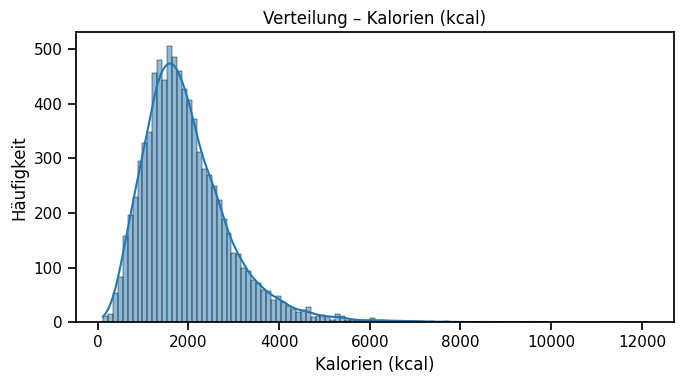

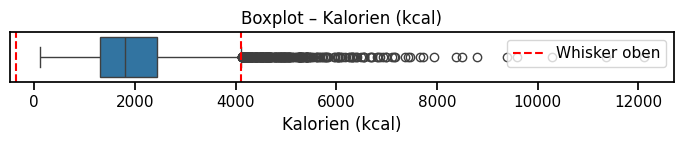

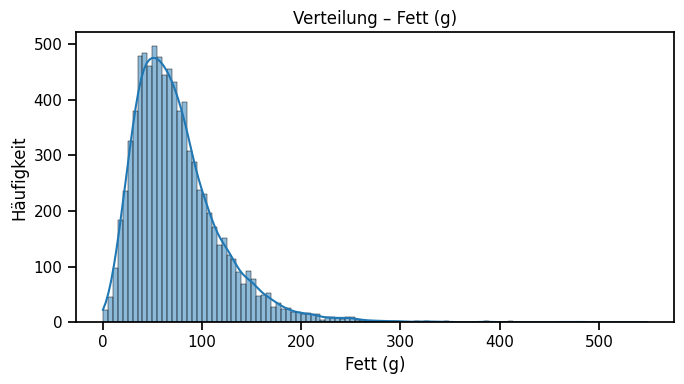

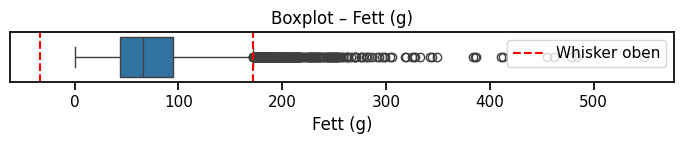

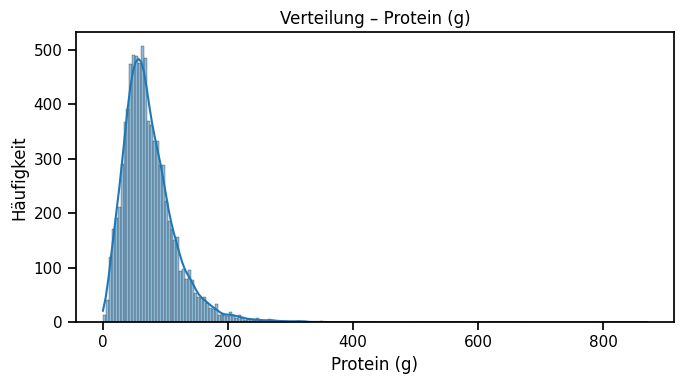

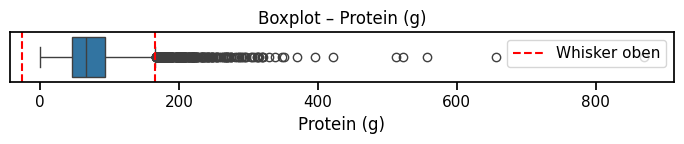

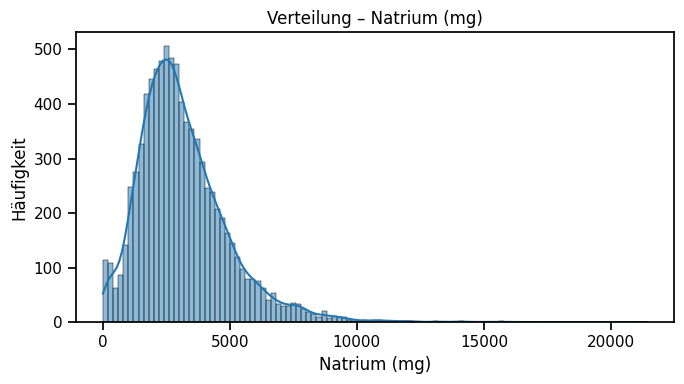

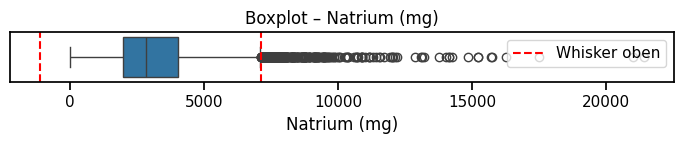

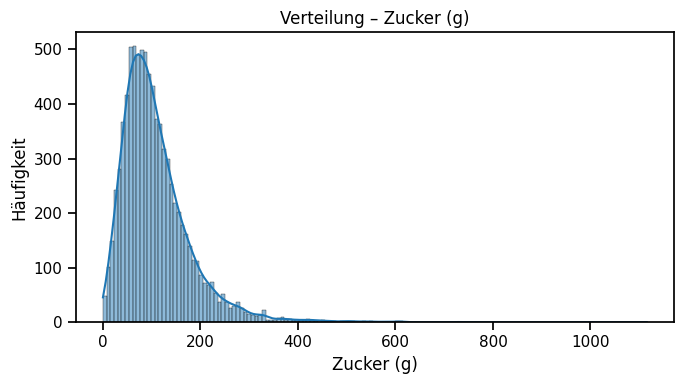

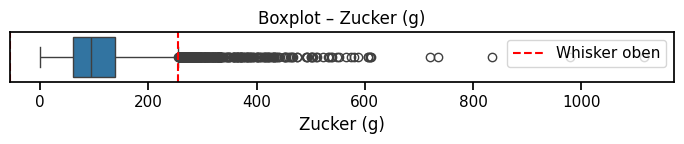

In [35]:
plot_distributions(df_bereinigt)

In [36]:
# Block 5 – NHANES + BLV zusammenführen  (Merge)
# ------------------------------------------------
# Zweck
#   • Ergänzt df_bereinigt (NHANES-Personen) mit den Referenzwerten aus df_blv_final.
#   • Erzeugt Flags, ob Kalorien / Fett / Natrium / Protein den
#     persönlichen Richtwert überschreiten.
#
# Was entsteht?
#   - df_merged  (DataFrame mit allen NHANES-Spalten + Referenz- & Flag-Spalten)
#
# Nutzung in 2 Schritten
#   1. Diese Zelle **einmal** ausführen  →  Funktion merge_with_blv() ist definiert.
#   2. Gleich danach **eine** Zeile ausführen:
#        df_merged = merge_with_blv(df_bereinigt, df_blv_final)
#      (Voraussetzung: df_bereinigt aus Block 2, df_blv_final aus Block 3
#       befinden sich bereits im Arbeitsspeicher.)
#
# Danach kannst du dir df_merged anschauen oder mit Block 6 weitermachen.

from typing import Tuple
import pandas as pd
import logging

# ---------------------------------------------------------------------------
# 1) feste Parameter
# ---------------------------------------------------------------------------
PUFFER      = 1.15   # 15 % Sicherheitsaufschlag oberhalb der Referenz
PAL_THRESH1 = 150    # Minuten/Woche – Grenze low / moderate
PAL_THRESH2 = 300    # Minuten/Woche – Grenze moderate / high

# ---------------------------------------------------------------------------
# 2) Helper – PAL aus Minuten/Woche ableiten
# ---------------------------------------------------------------------------
def _classify_pal(min_week: float | int | pd.NA) -> str:
    """Gibt 'low', 'moderate' oder 'high' zurück."""
    if pd.isna(min_week):
        return "moderate"           # fehlender Wert ⇒ Mittelwert
    if min_week < PAL_THRESH1:
        return "low"
    if min_week <= PAL_THRESH2:
        return "moderate"
    return "high"

# ---------------------------------------------------------------------------
# 3) Hauptfunktion
# ---------------------------------------------------------------------------
def merge_with_blv(
    df_bereinigt: pd.DataFrame,
    df_blv_final: pd.DataFrame,
) -> pd.DataFrame:
    """Führt NHANES-Daten mit BLV-Referenzen zusammen und berechnet Flags."""
    df = df_bereinigt.copy()

    # Geschlecht & Alter in Hilfsspalten für den Join
    df["sex"]       = df["RIAGENDR"].map({1: "male", 2: "female"})
    df["age_years"] = df["RIDAGEYR"].round().astype(int)
    df["pal"]       = df["PAD615"].apply(_classify_pal)

    # Merge: inner = Behält nur Zeilen, für die es BLV-Referenzen gibt
    df_merged = df.merge(
        df_blv_final,
        how="left",
        on=["sex", "age_years", "pal"],
    )

    # Sicherstellen, dass es keine doppelten IDs gibt
    assert not df_merged["SEQN"].duplicated().any()

    # Referenz-Grenzen in Gramm berechnen
    df_merged["fat_max_g"]     = df_merged["energy_kcal"] * df_merged["fat_pct_tei"] / 100 / 9
    df_merged["protein_max_g"] = 1.2 * df_merged["BMXWT"]          # 1.2 g pro kg Körpergewicht
    df_merged["sodium_max_mg"] = df_merged["sodium_g"] * 1000

    # Überschreitungs-Flags (True = alles im grünen Bereich)
    df_merged["kalorien_ok"] = df_merged["DR1TKCAL"] <= df_merged["energy_kcal"] * PUFFER
    df_merged["fett_ok"]     = df_merged["DR1TTFAT"] <= df_merged["fat_max_g"]   * PUFFER
    df_merged["natrium_ok"]  = df_merged["DR1TSODI"] <= df_merged["sodium_max_mg"] * PUFFER
    df_merged["protein_ok"]  = df_merged["DR1TPROT"] <= df_merged["protein_max_g"] * PUFFER

    logging.info("Block 5: Merge fertig – Zeilen: %d", len(df_merged))
    return df_merged

# ---------------------------------------------------------------------------
# Hier NICHTS aufrufen – die Funktion ist nun definiert.
# In der nächsten Zelle bitte:
#   df_merged = merge_with_blv(df_bereinigt, df_blv_final)


In [37]:
df_merged = merge_with_blv(df_bereinigt, df_blv_final)

In [38]:
df_merged.head()

,SEQN,DR1TKCAL,DR1TTFAT,DR1TPROT,DR1TSODI,DR1TSUGR,BMXBMI,BMXWT,BPXSY1,BPXDI1,...,energy_kcal,fat_pct_tei,sodium_g,fat_max_g,protein_max_g,sodium_max_mg,kalorien_ok,fett_ok,natrium_ok,protein_ok
0,73557,1574.0,52.81,43.63,1323.0,176.47,26.7,78.3,122.0,72.0,...,NaN,NaN,NaN,NaN,93.96,NaN,False,False,False,True
1,73558,5062.0,124.29,338.13,9726.0,44.99,28.6,89.5,156.0,62.0,...,NaN,NaN,NaN,NaN,107.40,NaN,False,False,False,False
2,73559,1743.0,65.97,64.61,2943.0,102.90,28.9,88.9,140.0,90.0,...,NaN,NaN,NaN,NaN,106.68,NaN,False,False,False,True
3,73560,1490.0,58.27,77.75,2745.0,80.58,17.1,32.2,108.0,38.0,...,NaN,NaN,NaN,NaN,38.64,NaN,False,False,False,False
4,73561,1421.0,55.36,55.24,797.0,87.78,19.7,52.0,136.0,86.0,...,NaN,NaN,NaN,NaN,62.40,NaN,False,False,False,True


In [40]:
df_final = apply_plausibility(df_merged)

**Prüfung der NHANES Dateneinträge auf Plausibilitä**

Die Verteilung, welche wir unter Block 4 gesehen haben, zeigt noch etliche Ausreissr.  Basierend auf aktuellen Empfehlungen von WHO / USDA / AHA und den Schweizer BLV-Referenzwerten entfernen wir

* **biologisch unmögliche Einträge** (z. B. mehr Fett-Kalorien als Gesamt-Kalorien)  
* **akut gesundheitsgefährdende Mengen** (z. B. > 12 g Natrium)  
* **extreme Kalorien-Tage (> 4 000 kcal)** – **aber nur dann**, wenn weder ein erhöhter BMI noch ≥ 420 min/Woche Aktivität diese Menge plausibel machen.  

WHO beschreibt Übergewicht als Folge einer *„Energie-Imbalance zwischen Kalorienzufuhr und -verbrauch“* und empfiehlt, die Energieaufnahme zu begrenzen.
Bei anhaltend Überschuss würde der BMI langfristig steigen.  
Die WHO-Leitlinie für Erwachsene nennt ≥ 150 min moderate Bewegung pro Woche als Minimum; zusätzliche Vorteile treten ab ≈ 300 min auf.

Wir setzen den **Aktivitäts-Plausibilitäts‐Schwellenwert** bei 420 min/W (= 1 h/Tag), um aktive Personen nicht fälschlich auszuschliessen.

| Regel | Schwellenwerte (Ausschluss) | Quelle / Begründung |
|---|---|---|
| **Kalorien** |  > 4 000 kcal / Tag **und** nicht durch BMI ≥ Referenz × Faktor **oder** ≥ 420 min/W moderate Aktivität erklärbar | USDA Food-Patterns decken 1 000–3 200 kcal für fast alle Erwachsenen :contentReference[oaicite:2]{index=2}; FAO/WHO-Berichte zeigen selbst bei schwerer Arbeit selten > 3 800 kcal |
| **Natrium** |  > 12 000 mg / Tag **oder** > 5 × persönliche BLV-Obergrenze | WHO empfiehlt < 2 000 mg :contentReference[oaicite:3]{index=3}; klinische Berichte über Hypernatriämie ab ≈ 10 000 mg |
| **Fett** | 1) Fett (g) > kcal / 9 × 1,05 ( > 105 % Energie aus Fett ) <br>2) Fett > 2 × BLV-Obergrenze | 1 g Fett = 9 kcal ⇒ mehr Fett-Kalorien als Gesamt-Kalorien ist physikalisch unmöglich |
| **Protein** | 1) > 3 g / kg Körpergewicht <br>2) > 2 × BLV-Obergrenze | Harvard Health empfiehlt dauerhaft ≤ 2 g/kg; Reviews setzen das tolerable Upper Level bei ≈ 3,5 g/kg |
| **15 %-Puffer** | Alle Checks greifen erst oberhalb 1,15 × BLV-Richtwert | berücksichtigt Messungenauigkeit & normale Tages­schwankungen |

*(BLV = Bundesamt für Lebensmittelsicherheit und Veterinärwesen, Schweiz)*

In [46]:
# Block 6 –  Plausibilitaets-Filter
# ----------------------------------------
# 1)  Personen mit > 4 000 kcal / Tag bleiben NUR,
#     wenn ihr hoher Wert sich durch BMI ODER Aktivitaet erklaeren laesst.
# 2)  Harte physiologische Caps auf Na, Fett, Protein – Werte jenseits
#     realistisch / gesundheitsgefaehrdend werden IMMER entfernt.
#
#    –> Ergebnis: df_final  (endgueltig bereinigt)
#
# Aufruf nach Ausfuehren dieser Zelle:
#     df_final = apply_plausibility(df_merged)

import pandas as pd
import logging

# -------------------------------------------------------------------
# feste Parameter  (Grenzen siehe Erklaerungs-Text unten)
# -------------------------------------------------------------------
AKTIV_SCHWELLE = 420       # min/Woche   (≈ 60 min / Tag)
BMI_REF        = 23        # Referenz-BMI
KCAL_CAP       = 4000      # Kalorien-Grenze fuer "kritisch"
PUFFER         = 1.15      # 15 % Toleranz ueber BLV-Wert

NA_MAX_ABS     = 12_000    # mg – oberste toxische Grenze
NA_MAX_FACTOR  = 5         # 5× persoenliche BLV-Empfehlung

FAT_ENERGY_PAD = 1.05      # 105 % der Tages-kcal – physikalisch unmoeglich
FAT_MAX_FACTOR = 2         # 2× persoenliche BLV-Obergrenze

PROT_GKG_MAX   = 3.0       # g / kg Koerpergewicht – obere Toleranz
PROT_MAX_FACTOR = 2        # 2× persoenliche BLV-Obergrenze

def apply_plausibility(df_merged: pd.DataFrame) -> pd.DataFrame:
    df = df_merged.copy()

    # 1) Kalorien-Outlier markieren
    kal_p85 = df["DR1TKCAL"].quantile(0.85)
    df["prüfen_aktivität"] = (
        (~df["kalorien_ok"]) &
        (df["DR1TKCAL"] > KCAL_CAP)
    )

    # 2) Kritische Personen extrahieren
    krit = df[df["prüfen_aktivität"]].copy()

    # 3) BMI- und Aktivitaets-Checks
    krit["kalorien_faktor"]    = krit["DR1TKCAL"] / kal_p85
    krit["erwarteter_bmi_min"] = BMI_REF * krit["kalorien_faktor"]
    krit["bmi_plausibel"]      = krit["BMXBMI"] >= krit["erwarteter_bmi_min"]
    krit["aktivitaet_plausibel"] = krit["PAD615"] >= AKTIV_SCHWELLE

    raus_ids = krit.loc[
        (~krit["bmi_plausibel"]) & (~krit["aktivitaet_plausibel"]),
        "SEQN"
    ]

    # 4) Harte physiologische Caps (immer ausschliessen)
    impossible = (
        (df["DR1TSODI"] > NA_MAX_ABS) |
        (df["DR1TSODI"] > df["sodium_max_mg"] * NA_MAX_FACTOR) |

        (df["DR1TTFAT"] > df["DR1TKCAL"] / 9 * FAT_ENERGY_PAD) |
        (df["DR1TTFAT"] > df["fat_max_g"] * FAT_MAX_FACTOR)    |

        (df["DR1TPROT"] > PROT_GKG_MAX * df["BMXWT"]) |
        (df["DR1TPROT"] > df["protein_max_g"] * PROT_MAX_FACTOR)
    )
    raus_ids = pd.concat([raus_ids, df.loc[impossible, "SEQN"]]).unique()

    df_final = df[~df["SEQN"].isin(raus_ids)].copy()
    logging.info(
        "Block 6: entfernt %d Personen – verbleiben %d",
        len(raus_ids), len(df_final)
    )
    return df_final


In [47]:
# Block 7 – Master-Plotter  (Visualisiert df_final)
# -------------------------------------------------
# Zweck
#   • Erstellt fuer jede ausgewaehlte Naehrwert-Spalte
#     – Histogramm mit glatter Kurve
#     – Boxplot mit IQR-Whiskern
#
# Vorgehen im Notebook
#   1. Diese Zelle EINMAL ausfuehren  →  Funktion plot_final() ist definiert.
#   2. Gleich danach   plot_final(df_final)   aufrufen.
#
#   Voraussetzung: df_final stammt aus Block 6 und ist bereits im Speicher.

from typing import Dict
import matplotlib.pyplot as plt
import pandas as pd
import logging

# ---------------------------------------------------------------------------
# 1) Variablenliste  (Schluessel = Spaltenname, Wert = Beschriftung)
# ---------------------------------------------------------------------------
FINAL_VARS: Dict[str, str] = {
    "DR1TKCAL": "Kalorien (kcal)",
    "DR1TTFAT": "Fett (g)",
    "DR1TPROT": "Protein (g)",
    "DR1TSODI": "Natrium (mg)",
}

# ---------------------------------------------------------------------------
# 2) Plot-Funktion
# ---------------------------------------------------------------------------
def plot_final(df: pd.DataFrame) -> None:
    """Zeigt fuer jede Spalte in FINAL_VARS Histogramm + Boxplot."""
    import seaborn as sns
    sns.set_context("notebook", font_scale=1.0)

    for col, label in FINAL_VARS.items():
        if col not in df.columns:
            logging.warning("Spalte %s fehlt – uebersprungen", col)
            continue

        vals = df[col].dropna()

        # ---------- Histogramm ----------
        plt.figure(figsize=(7, 4))
        sns.histplot(vals, kde=True, bins="auto")
        plt.title(f"Verteilung – {label}")
        plt.xlabel(label)
        plt.ylabel("Haeufigkeit")
        plt.tight_layout()
        plt.show()

        # ---------- Boxplot ----------
        q1, q3 = vals.quantile([0.25, 0.75])
        iqr = q3 - q1
        upper = q3 + 1.5 * iqr
        lower = q1 - 1.5 * iqr

        plt.figure(figsize=(7, 1.6))
        sns.boxplot(x=vals)
        plt.axvline(upper, ls="--", c="red", label="Whisker oben")
        plt.axvline(lower, ls="--", c="red")
        plt.title(f"Boxplot – {label}")
        plt.xlabel(label)
        plt.yticks([])
        plt.legend()
        plt.tight_layout()
        plt.show()

    logging.info("Block 7: alle Plots erstellt.")

# ---------------------------------------------------------------------------
# Hier nichts weiter aufrufen.
# Danach in neuer Zelle:
#     plot_final(df_final)


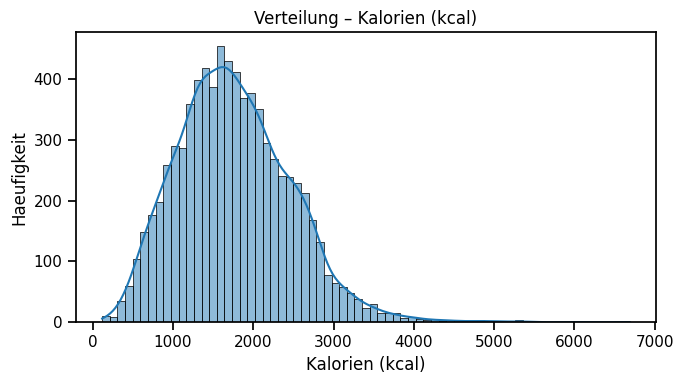

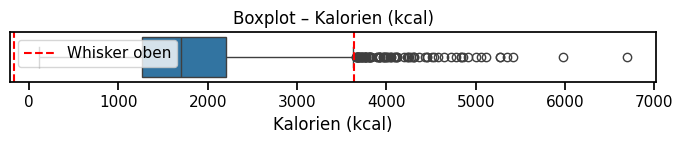

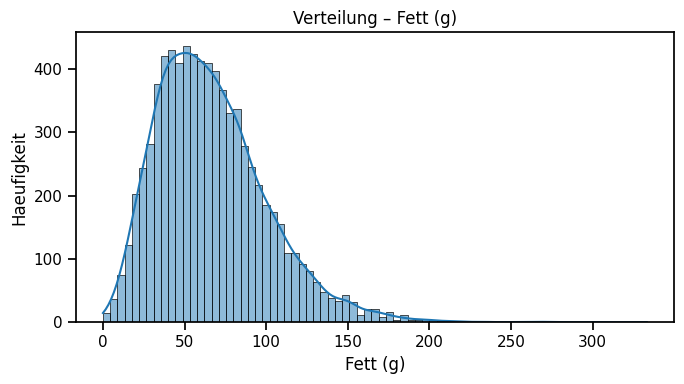

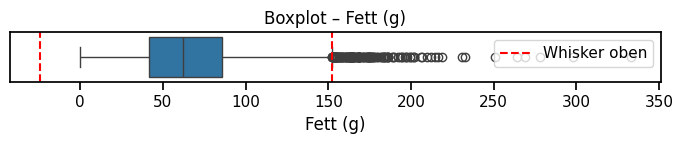

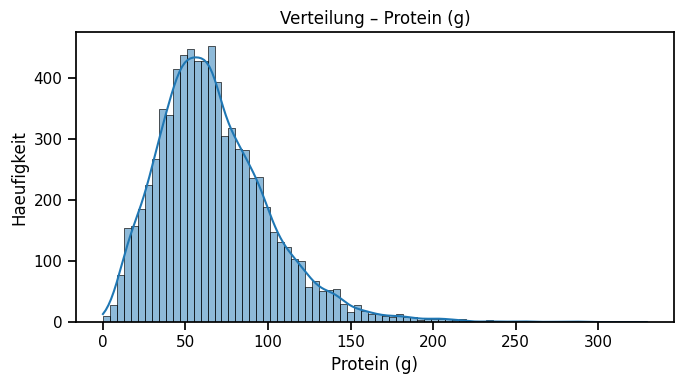

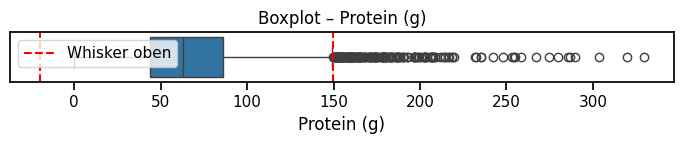

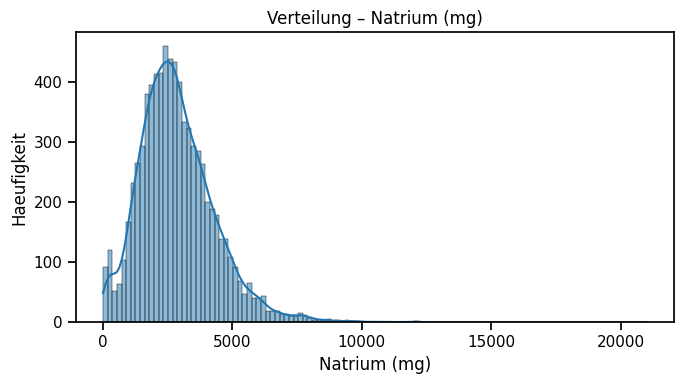

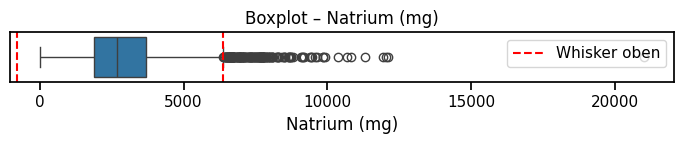

In [43]:
plot_final(df_final)

# Feature Engeneering

NHANES Datensatz

Engineering um fehlende BMI Wert aufzufüllen

In [82]:
#Feature Engeneering BMI: Fehlende BMI-Wert bei den 758 Datensätzen durch Körpergewicht und Körpergrösse berechnen

# Voraussetzung:
# - WHD010: Körpergröße in cm
# - WHD020: Körpergewicht in kg
# - BMXBMI: BMI (wenn vorhanden)

# Formel: BMI = Gewicht (kg) / (Größe in m)^2
def berechne_bmi(row):
    if pd.isna(row['BMXBMI']) and not pd.isna(row['WHD010']) and not pd.isna(row['WHD020']):
        groesse_m = row['WHD010'] / 100
        return row['WHD020'] / (groesse_m ** 2)
    return row['BMXBMI']

# Zähle vorher, wie viele BMI-Werte fehlen
missing_bmi_before = df['BMXBMI'].isna().sum()

# Wende die Berechnung an
df['BMXBMI'] = df.apply(berechne_bmi, axis=1)

# Zähle nachher, wie viele noch fehlen
missing_bmi_after = df['BMXBMI'].isna().sum()
recovered = missing_bmi_before - missing_bmi_after

print(f"BMI-Werte ergänzt: {recovered} von {missing_bmi_before} fehlenden Fällen")


BMI-Werte ergänzt: 79 von 758 fehlenden Fällen


Engineering Gesundheitszustand: Übergewicht, Bluthochdruck, Diabetes oder gesund

<ipython-input-83-e1d8d3aff373>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


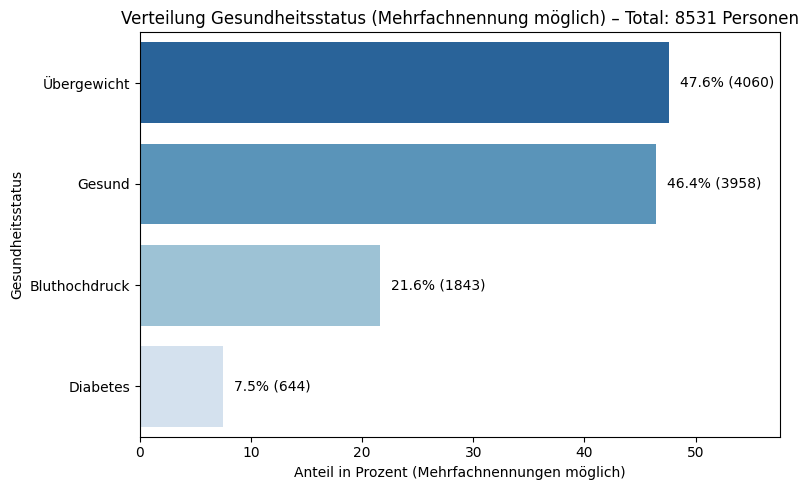

In [83]:
#Feature erstellen für Krankheiten - Übergewicht; Bluthochdruck und Diabetes
#es werden nur solche als gesund klassifiziert welche weder übergewichtig sind, oder an Bluthochdruck oder Diabetes leiden.
import matplotlib.pyplot as plt
import seaborn as sns

# Neue Diagnosefunktion – erlaubt mehrere Krankheiten pro Person
def get_diagnosen(row):
    diagnosen = []
    if row['DIQ010'] == 1:
        diagnosen.append('Diabetes')
    if row['BPXSY1'] >= 130 or row['BPXDI1'] >= 80:
        diagnosen.append('Bluthochdruck')
    if row['BMXBMI'] >= 25:
        diagnosen.append('Übergewicht')
    if not diagnosen:
        diagnosen.append('Gesund')
    return diagnosen

# Liste an Diagnosen pro Person erzeugen
df_bereinigt['diagnosen_liste'] = df_bereinigt.apply(get_diagnosen, axis=1)

# Jetzt alle Diagnosen in eine einzige Serie umwandeln und zählen
alle_diagnosen = df_bereinigt['diagnosen_liste'].explode()
diagnose_counts = alle_diagnosen.value_counts()
diagnose_percent = (diagnose_counts / len(df_bereinigt) * 100).round(1)

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    y=diagnose_percent.index,
    x=diagnose_percent.values,
    orient='h',
    palette='Blues_r'
)

# Prozent- und Absolutwerte auf Balken schreiben
for i, (label, value) in enumerate(diagnose_percent.items()):
    abs_val = diagnose_counts[label]
    ax.text(value + 1, i, f"{value:.1f}% ({abs_val})", va='center')

# Titel & Achsen
gesamt = len(df_bereinigt)
plt.title(f"Verteilung Gesundheitsstatus (Mehrfachnennung möglich) – Total: {gesamt} Personen")
plt.xlabel("Anteil in Prozent (Mehrfachnennungen möglich)")
plt.ylabel("Gesundheitsstatus")
plt.xlim(0, max(diagnose_percent.values) + 10)
plt.tight_layout()
plt.show()


In [84]:
#Personen mit mehren "Krankheiten"
# Neue binäre Spalten für Auswertung erzeugen
df_bereinigt['übergewichtig'] = df_bereinigt['BMXBMI'] >= 25
df_bereinigt['bluthochdruck'] = (df_bereinigt['BPXSY1'] >= 130) | (df_bereinigt['BPXDI1'] >= 80)
df_bereinigt['diabetes'] = df_bereinigt['DIQ010'] == 1

# Kreuztabellen
pd.set_option('display.max_rows', None)  # alle Zeilen anzeigen

# Wie viele übergewichtige Personen haben zusätzlich Bluthochdruck oder Diabetes?
kombination = df_bereinigt.groupby('übergewichtig')[['bluthochdruck', 'diabetes']].sum()

# Zusätzlich: Gesamtanzahl in jeder Gruppe
anzahl_pro_gruppe = df_bereinigt['übergewichtig'].value_counts()

# Ausgabe als schöne Übersicht
print("Verteilung innerhalb der Übergewichts-Gruppen:\n")
print(kombination)
print("\nGesamtanzahl pro Gruppe (übergewichtig / nicht übergewichtig):")
print(anzahl_pro_gruppe)

# Optional: Prozentwerte berechnen
prozent = (kombination.T / anzahl_pro_gruppe.values).T.round(2)
print("\nAnteil innerhalb jeder Gruppe (in Prozent):")
print(prozent * 100)


Verteilung innerhalb der Übergewichts-Gruppen:

               bluthochdruck  diabetes
übergewichtig                         
False                    461        98
True                    1382       546

Gesamtanzahl pro Gruppe (übergewichtig / nicht übergewichtig):
übergewichtig
False    4471
True     4060
Name: count, dtype: int64

Anteil innerhalb jeder Gruppe (in Prozent):
               bluthochdruck  diabetes
übergewichtig                         
False                   10.0       2.0
True                    34.0      13.0


Engineering Klassifizieren von Raucher/nicht Rauchern

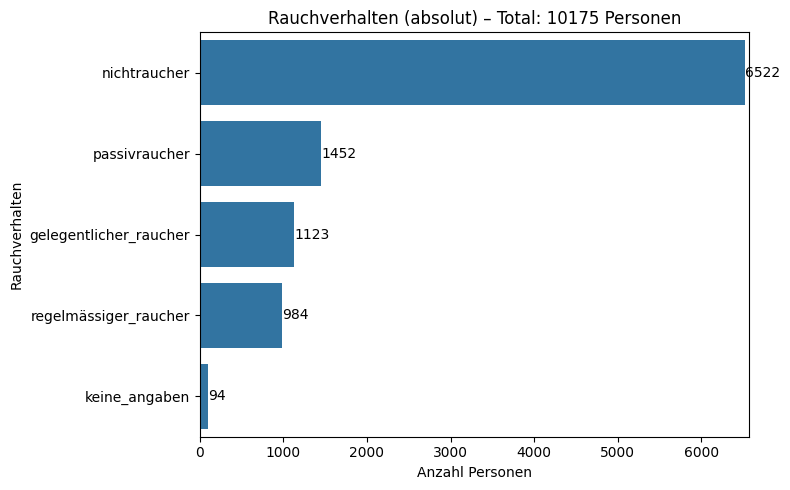

In [85]:
#Feature engeenering für Klassifikation von: "" nicht raucher, passiv Raucher, gelegenheits Raucher, regelmässiger Raucher"
#falls ein Person selbst raucht wird die Tatsache, dass sie/er allfällig in einem Haushalt lebt wo andere Personen ebenfalls rauchen vernachlässigt. Da dies gesundheitlich nicht mehr eine grosse Relevanz hat

def klassifiziere_raucher(row):
    smq621 = row.get("SMQ621")
    smq710 = row.get("SMQ710")
    smd460 = row.get("SMD460")

    if pd.isna(smq621) and pd.isna(smq710) and pd.isna(smd460):
        return "keine_angaben"

    if not pd.isna(smq710) and smq710 >= 3:
        return "regelmässiger_raucher"
    elif not pd.isna(smq710) and 1 <= smq710 <= 2:
        return "gelegentlicher_raucher"
    elif not pd.isna(smq621) and smq621 >= 100:
        return "regelmässiger_raucher"
    elif not pd.isna(smq621) and 1 <= smq621 < 100:
        return "gelegentlicher_raucher"
    elif not pd.isna(smd460) and smd460 >= 1:
        return "passivraucher"
    else:
        return "nichtraucher"

def klassifiziere_alkohol(row):
    alq110 = row.get("ALQ110")
    alq120q = row.get("ALQ120Q")

    if pd.isna(alq110) and pd.isna(alq120q):
        return "keine_angaben"

    if alq110 == 2:
        return "konsumiert_keinen_alkohol"

    if not pd.isna(alq120q):
        if alq120q == 0:
            return "konsumiert_keinen_alkohol"
        elif 1 <= alq120q <= 3:
            return "gelegentlich"
        elif 4 <= alq120q <= 6:
            return "regelmässig"
        elif alq120q >= 7:
            return "regelmässig_und_viel"

    return "keine_angaben"

# Neue Spalten erstellen
questionnaire["rauchverhalten_kategorie"] = questionnaire.apply(klassifiziere_raucher, axis=1)
questionnaire["alkoholkonsum_kategorie"] = questionnaire.apply(klassifiziere_alkohol, axis=1)

# Zähle die Kategorien
rauch_counts_abs = questionnaire["rauchverhalten_kategorie"].value_counts()
gesamt_anzahl_rauch = rauch_counts_abs.sum()

# Plot erstellen
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    y=rauch_counts_abs.index,
    x=rauch_counts_abs.values,
    orient="h",
    color="#1f77b4"  # Gleiche Farbe wie für Krankheiten
)

# Zahlen in Balken einfügen
for i, (label, value) in enumerate(rauch_counts_abs.items()):
    ax.text(value + 5, i, f"{value}", va="center", fontsize=10)

# Titel und Achsen
plt.title(f"Rauchverhalten (absolut) – Total: {gesamt_anzahl_rauch} Personen")
plt.xlabel("Anzahl Personen")
plt.ylabel("Rauchverhalten")
plt.xlim(0, max(rauch_counts_abs.values) + 50)
plt.tight_layout()
plt.show()


Engineering von Klassifizierungen im Bezug auf Alkoholkonsum

<ipython-input-86-43942d96fed1>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


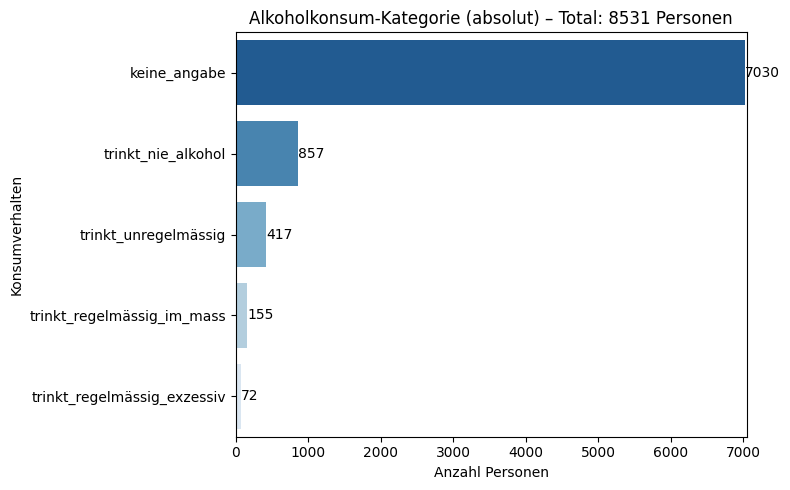

In [86]:
# Ziel: Personen systematisch in vier Gruppen einteilen basierend auf:
# - ob sie jemals Alkohol konsumiert haben (ALQ110)
# - wie häufig sie im letzten Jahr getrunken haben (ALQ120Q)
# - ob sie jemals eine Phase mit exzessivem Konsum hatten (ALQ151)
#
# Kategorien:
# - 'trinkt_nie_alkohol':      noch nie ≥12 Drinks im Leben (ALQ110 = 2)
# - 'trinkt_unregelmässig':    ALQ110 = 1, aber ALQ120Q ≤ 1x/Monat oder fehlt
# - 'trinkt_regelmässig_im_mass': ALQ110 = 1, ALQ120Q = 1–4x/Woche, keine Exzesse (ALQ151 ≠ 1)
# - 'trinkt_regelmässig_exzessiv': ALQ110 = 1, und ALQ151 = 1 oder ALQ120Q ≥ 5x/Woche

def klassifiziere_alkohol(row):
    if row['ALQ110'] == 2:
        return 'trinkt_nie_alkohol'
    elif row['ALQ110'] == 1:
        if pd.isna(row['ALQ120Q']):
            return 'trinkt_unregelmässig'  # keine Frequenzangabe trotz grundsätzlich Konsum
        elif row['ALQ120Q'] <= 1:
            return 'trinkt_unregelmässig'
        elif row['ALQ151'] == 1 or row['ALQ120Q'] >= 5:
            return 'trinkt_regelmässig_exzessiv'
        else:
            return 'trinkt_regelmässig_im_mass'
    return 'keine_angabe'

# Wende Klassifikation an
df_bereinigt['alkoholkonsum_kategorie'] = df_bereinigt.apply(klassifiziere_alkohol, axis=1)

# Berechne absolute Anzahl pro Kategorie
alkohol_counts_abs = df_bereinigt['alkoholkonsum_kategorie'].value_counts()
gesamt_anzahl = alkohol_counts_abs.sum()  # Gesamtzahl der klassifizierten Fälle

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    y=alkohol_counts_abs.index,
    x=alkohol_counts_abs.values,
    orient='h',
    palette='Blues_r'
)

# Zahlen auf Balken schreiben
for i, (label, value) in enumerate(alkohol_counts_abs.items()):
    ax.text(value + 1, i, f"{value}", va='center')

# Titel und Achsen
plt.title(f"Alkoholkonsum-Kategorie (absolut) – Total: {gesamt_anzahl} Personen")
plt.xlabel("Anzahl Personen")
plt.ylabel("Konsumverhalten")
plt.xlim(0, max(alkohol_counts_abs.values) + 20)
plt.tight_layout()
plt.show()

Kombination von Rauch- und Trinkverhalten

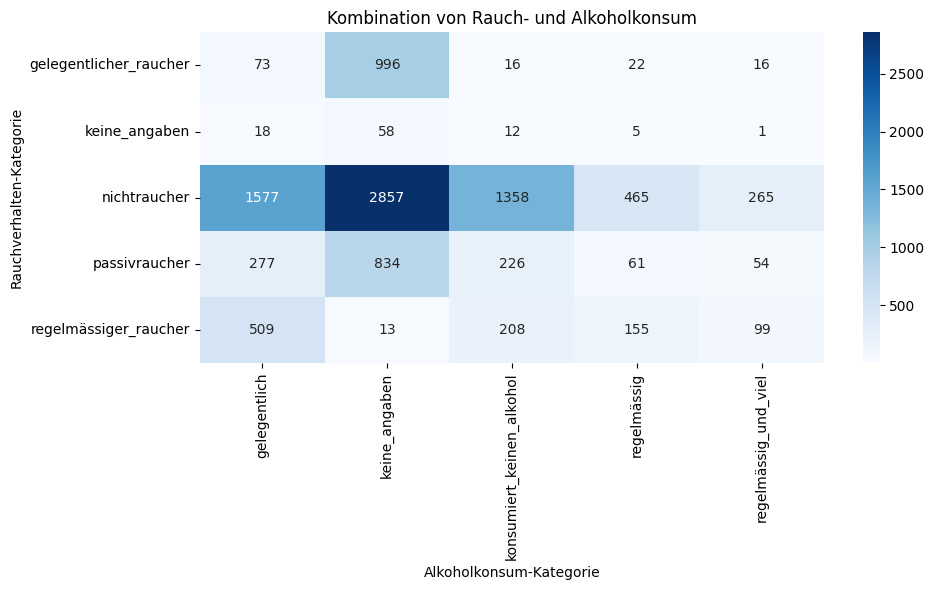

In [87]:
# Kreuztabelle erstellen
kreuz = pd.crosstab(
    questionnaire['rauchverhalten_kategorie'],
    questionnaire['alkoholkonsum_kategorie']
)

# Heatmap darstellen
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(kreuz, annot=True, fmt="d", cmap="Blues")
plt.title("Kombination von Rauch- und Alkoholkonsum")
plt.xlabel("Alkoholkonsum-Kategorie")
plt.ylabel("Rauchverhalten-Kategorie")
plt.tight_layout()
plt.show()


# KAQ 1: In welchen Ernährungsgewohnheiten liegt eine potenziell unausgewogene Nährstoffzufuhr vor?

**Erster exoloratives Clustering**
Bevor wir die Daten einem vordefinierten Kategorienschema unterwarfen, haben wir exploratives Clustering auf Basis der individuellen Nährstoffaufnahme durchgeführt. Der Abstand innerhalb der Punkt innerhalb des Cluster reduziert sich am stärksten zwischen 2-4 Cluster. Dementsprechend wir gehen wir von 3 Cluster aus. Der Silhouette Score von 0.244 zeigt jedoch auf, dass zwar Cluster vorhanden sind aber nicht sehr klar von einander trennbar sind.

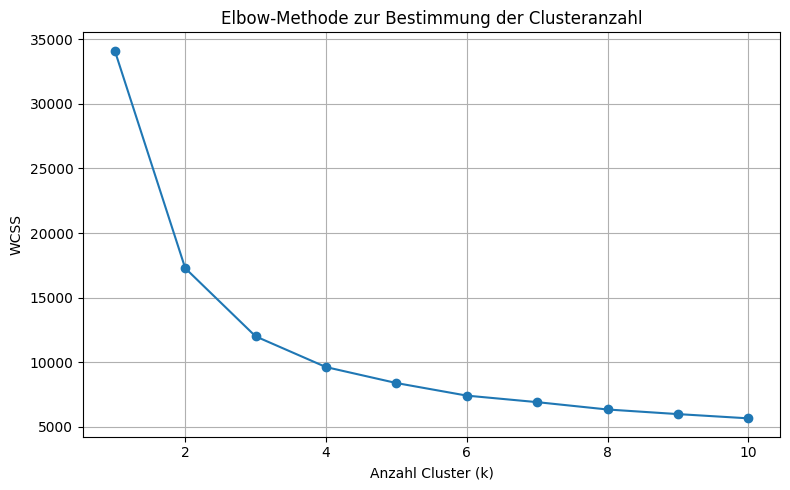

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# STEP 1: Cluster-relevante Spalten extrahieren
cluster_features = ['DR1TKCAL', 'DR1TTFAT', 'DR1TPROT', 'DR1TSODI']
df_cluster = df_bereinigt[cluster_features].dropna()

# STEP 2: Daten standardisieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# STEP 3: Elbow-Methode zur Bestimmung der optimalen Clusterzahl
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# STEP 4: Plot anzeigen
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow-Methode zur Bestimmung der Clusteranzahl")
plt.xlabel("Anzahl Cluster (k)")
plt.ylabel("WCSS")
plt.grid(True)
plt.tight_layout()
plt.show()


In [90]:
#Prüfen der Qualität bei verschieder Clusteranzahl von 2-10 Clustern (Cluster sind basierend auf standartisierten Rohdaten - nicht Differenzwerten)

from sklearn.preprocessing import StandardScaler

# Wähle die relevanten Features für Clustering
cluster_features = ['DR1TKCAL', 'DR1TTFAT', 'DR1TPROT', 'DR1TSODI']
df_cluster = df_bereinigt[cluster_features].dropna()

# Standardisierung
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Finde den besten k-Wert
for k in range(2, 11):  # von 2 bis 10 Cluster
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}: Silhouette Score = {score:.3f}")


k=2: Silhouette Score = 0.497
k=3: Silhouette Score = 0.409
k=4: Silhouette Score = 0.353
k=5: Silhouette Score = 0.313
k=6: Silhouette Score = 0.290
k=7: Silhouette Score = 0.277
k=8: Silhouette Score = 0.261
k=9: Silhouette Score = 0.260
k=10: Silhouette Score = 0.247


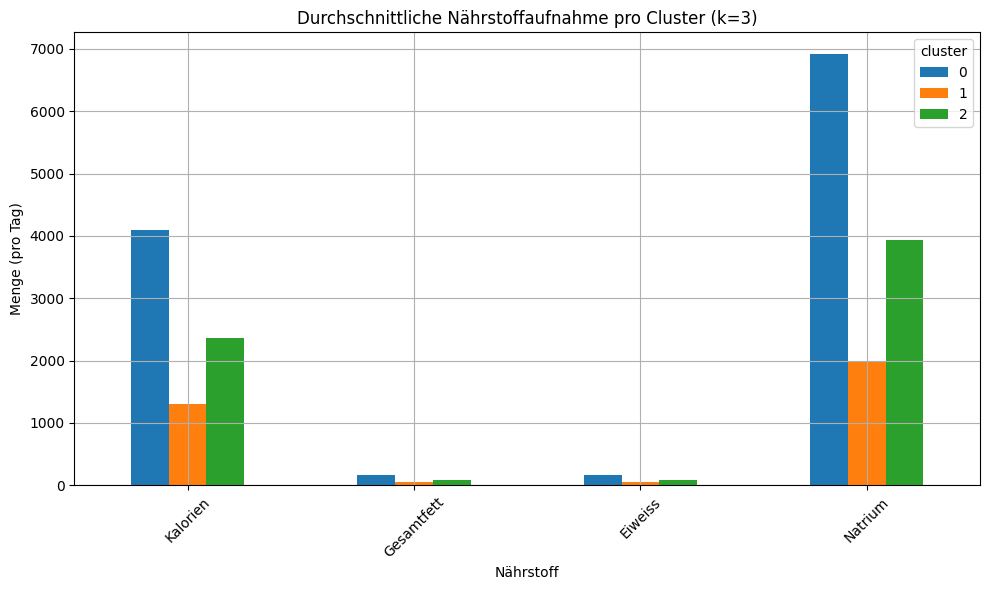

In [93]:
#Interpretation der Cluster k-3

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Cluster erstellen ---
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# --- Originalnamen zu Klartext umbenennen ---
benennung = {
    'DR1TKCAL': 'Kalorien',
    'DR1TTFAT': 'Gesamtfett',
    'DR1TPROT': 'Eiweiss',
    'DR1TSODI': 'Natrium'
}

# --- Gruppiere nach Cluster und berechne Mittelwerte ---
cluster_bedeutung = df_cluster.groupby('cluster')[cluster_features].mean()
cluster_bedeutung.rename(columns=benennung, inplace=True)

# --- Transponieren für besseres Barplot ---
cluster_bedeutung.T.plot(kind='bar', figsize=(10, 6))
plt.title("Durchschnittliche Nährstoffaufnahme pro Cluster (k=3)")
plt.ylabel("Menge (pro Tag)")
plt.xlabel("Nährstoff")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

